# Editing a scene

## Overview

In this tutorial, you will learn how to modify a Mitsuba scene after it has been loaded from a file. You might want to edit a scene before (re-)rendering it for many reasons. Maybe a corner is dim, or an object should be moved a bit to the left. Thankfully we can use the *traverse* mechanism to perform such modifications in Python with Mitsuba 3. As we will see in later tutorials, this mechanism is also essential for inverse rendering applications and more.

<div class="admonition important alert alert-block alert-success">

🚀 **You will learn how to:**

<ul>
  <li>List exposed parameters of Mitsuba objects</li>
  <li>Edit a scene and update its internal state accordingly</li>
</ul>

</div>

## Loading a scene

Following the same steps as in [Mitsuba quickstart tutorial][1], let's import `mitsuba`, set the desired variant and load a scene from an XML file on disk.

[1]: https://mitsuba.readthedocs.io/en/latest/src/quickstart/mitsuba_quickstart.html

In [218]:
import drjit as dr
import mitsuba as mi
mi.set_variant('llvm_ad_spectral')

scene = mi.load_file("../scenes/bunny_and_dragon.xml")

Let's quickly render this scene.

In [219]:
original_image = mi.render(scene, spp=128)

# Get the film
film = scene.sensors()[0].film()

# Convert to RGB automatically via bitmap() (which includes spectrum → RGB)
bitmap = film.bitmap(raw=False)
print(bitmap)

Bitmap[
  pixel_format = multichannel,
  component_format = float32,
  size = [768, 576],
  srgb_gamma = 0,
  struct = Struct<68>[
    float32 R; // @0, premultiplied alpha
    float32 G; // @4, premultiplied alpha
    float32 B; // @8, premultiplied alpha
    float32 image.R; // @12, premultiplied alpha
    float32 image.G; // @16, premultiplied alpha
    float32 image.B; // @20, premultiplied alpha
    float32 image.A; // @24, premultiplied alpha
    float32 albedo.R; // @28, premultiplied alpha
    float32 albedo.G; // @32, premultiplied alpha
    float32 albedo.B; // @36, premultiplied alpha
    float32 sh_normal.X; // @40, premultiplied alpha
    float32 sh_normal.Y; // @44, premultiplied alpha
    float32 sh_normal.Z; // @48, premultiplied alpha
    float32 depth.T; // @52, premultiplied alpha
    float32 position.X; // @56, premultiplied alpha
    float32 position.Y; // @60, premultiplied alpha
    float32 position.Z; // @64, premultiplied alpha
  ],
  data = [ 28.7 MiB of image

## AOVs
 Mistuba offers tutorials related to [<code>Arbitrary Output Variables integrator</code>][1]. The following function is defined for seperating different AOV and save them in corresponding .exr file.

 TO DO: double check how to get spectral albedo and convert it to RGB

[1]: https://mitsuba.readthedocs.io/en/stable/src/generated/plugins_integrators.html#arbitrary-output-variables-integrator-aov

In [220]:
import numpy as np
import matplotlib.pyplot as plt

def show_aov(aov, title, index):
    """Visualize an AOV"""
    global _axes

    ax = _axes[index]
    ax.imshow(aov)
    ax.set_title(title)
    ax.axis('off')

def save_all_aovs(bitmap):
    """Save spectral albedo, RGB albedo, shading normal, depth, and world position as separate EXR files."""
    res = dict(bitmap.split())

    # --- Save spectral albedo ---
    albedo_spectral = res['albedo'] 
    albedo_spectral.write("results/albedo-spectral.exr")
    show_aov(albedo_spectral, "Albedo", 0)
    
    
    # Convert spectral albedo to RGB and save
    #albedo_rgb = mi.util.spectrum_to_rgb(albedo_spectral)
    #albedo_rgb.write("results/albedo-rgb.exr")
    #show_aov(albedo_rgb, "RGB Albedo")

    # --- Save shading normal ---
    sh_normal = res['sh_normal']
    sh_normal.write("results/sh_normal.exr")
    show_aov(sh_normal, "Shading Normal", 1)

    # --- Save depth ---
    depth = res['depth']
    depth.write("results/depth.exr")
    show_aov(depth, "Depth", 2)

    # --- Save position ---
    position = res['position']
    position.write("results/world-pos.exr")
    show_aov(position, "Position", 3)

     # --- Save pathtraced image ---
    image = res['image'] # path-reaced RGB image
    image.write("results/color.exr")
    show_aov(image, "Path traced Image", 4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Channels in bitmap: ['R', 'G', 'B', 'image.R', 'image.G', 'image.B', 'image.A', 'albedo.R', 'albedo.G', 'albedo.B', 'sh_normal.X', 'sh_normal.Y', 'sh_normal.Z', 'depth.T', 'position.X', 'position.Y', 'position.Z']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


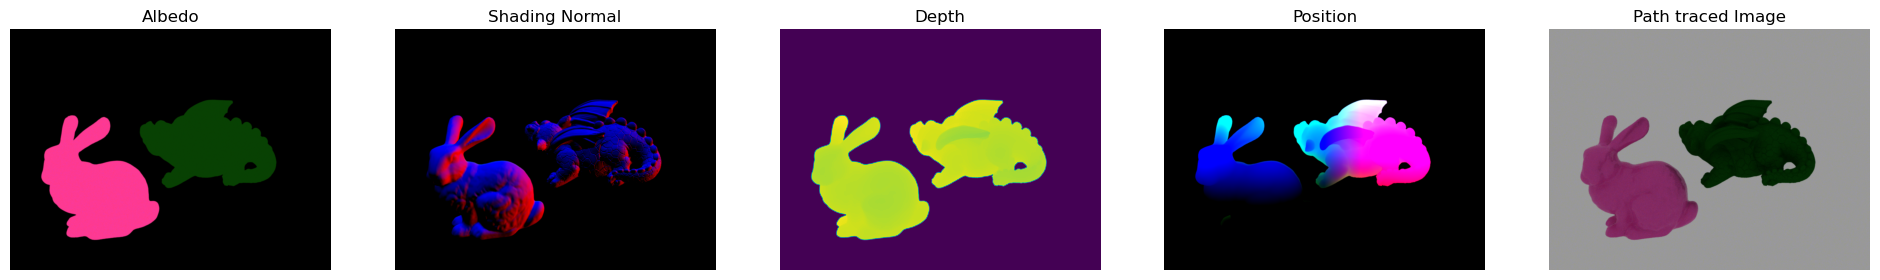

In [221]:
# Extract channel names
channel_names = [field.name for field in bitmap.struct_()]
print("Channels in bitmap:", channel_names)

# global variables
global _fig, _axes
_fig, _axes = plt.subplots(1, 5, figsize=(24, 4))

save_all_aovs(bitmap)

## Accessing scene parameters

Any Mitsuba object can be inspected using the [<code>traverse()</code>][1] function, which returns a instance of [<code>SceneParameters</code>][2]. It has a similar API to Python `dict` and holds all parameters that are exposed by the input object and its children. Therefore, when given a scene as input, this function will return the parameters of all the objects present in the scene.

Let's print the paramters available in our teapot scene.

[1]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.traverse
[2]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.SceneParameters

In [222]:
params = mi.traverse(scene)
print(params)

SceneParameters[
  ----------------------------------------------------------------------------------------------------
  Name                                             Flags    Type           Parent
  ----------------------------------------------------------------------------------------------------
  sensor.near_clip                                          float          PerspectiveCamera
  sensor.far_clip                                           float          PerspectiveCamera
  sensor.shutter_open                                       float          PerspectiveCamera
  sensor.shutter_open_time                                  float          PerspectiveCamera
  sensor.film.size                                          ScalarVector2u HDRFilm
  sensor.film.crop_size                                     ScalarVector2u HDRFilm
  sensor.film.crop_offset                                   ScalarPoint2u  HDRFilm
  sensor.x_fov                                     ∂, D     Float         